In [194]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50  import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop 


In [195]:
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [196]:
datagenerator = ImageDataGenerator()

In [197]:
datagenerator = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale= 1/255.,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.80,1.20],
    #fill_mode='nearest'    
)

In [217]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('../train/', 
    class_mode='binary',
    target_size=(256, 256), 
    batch_size=32, 
    shuffle=False,
    color_mode='rgb')

# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('../valid/', 
    class_mode='binary',
    target_size=(256, 256),
    batch_size=1, 
    shuffle=False,
    color_mode='rgb')

# load and iterate test dataset
test_data = datagenerator.flow_from_directory('../test/', 
    class_mode='binary',
    target_size=(256, 256),
    batch_size=1, 
    shuffle=False,
    color_mode='rgb')

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


In [218]:
train_data.classes.cumsum()

array([   0,    0,    0, ..., 2078, 2079, 2080])

The dimensions of the image are 256 pixels width and 256 pixels height, three channels.
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.3385 and the standard deviation is 0.3457


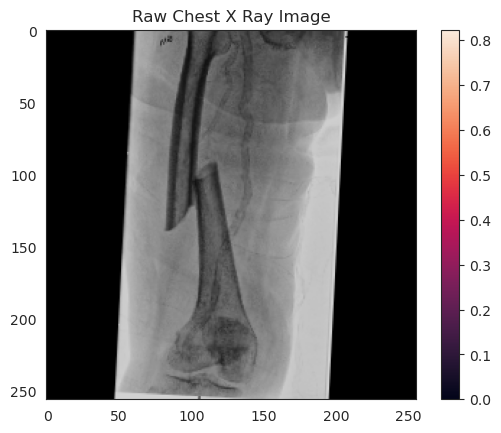

In [219]:
sns.set_style('white')
generated_image, label = train_data.__getitem__(0)
plt.imshow(generated_image[11])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, three channels.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [220]:
generated_image.shape

(32, 256, 256, 3)

In [221]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 256x256 with 3 bytes color

    # The first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    
    # add a dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.4),

    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [222]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 30, 30, 64)       

In [223]:
model.compile(loss='binary_crossentropy', optimizer= RMSprop(learning_rate=0.001), metrics=['acc'])

In [224]:
n_epochs = 20
batch_size = 64

In [225]:
total_sample=train_data.n

In [226]:
from sklearn.utils import class_weight

In [227]:
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))

In [228]:
weights

array([2.5  , 0.625])

In [229]:
dict_weights = {0: weights[0], 1:weights[1]}

In [230]:
dict_weights

{0: 2.5, 1: 0.625}

In [231]:
history = model.fit( train_data, validation_data= val_data, steps_per_epoch=int(total_sample/batch_size), epochs=n_epochs, verbose=1, class_weight=dict_weights)

Epoch 1/20


2022-11-30 10:30:34.523143: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 264257536 exceeds 10% of free system memory.
2022-11-30 10:30:35.153751: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 264257536 exceeds 10% of free system memory.


 1/40 [..............................] - ETA: 3:42 - loss: 0.4577 - acc: 0.1875

2022-11-30 10:30:38.716172: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 264257536 exceeds 10% of free system memory.
2022-11-30 10:30:39.268517: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 264257536 exceeds 10% of free system memory.


 2/40 [>.............................] - ETA: 2:36 - loss: 0.3448 - acc: 0.3906

2022-11-30 10:30:43.400535: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 264257536 exceeds 10% of free system memory.


40/40 [==============================] - ETA: 0s - loss: 4.0449 - acc: 0.7764

2022-11-30 10:33:17.345106: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at conv_ops_fused_impl.h:768 : Invalid argument: input depth must be evenly divisible by filter depth: 1 vs 3


InvalidArgumentError:  input depth must be evenly divisible by filter depth: 1 vs 3
	 [[node sequential_6/conv2d_36/Relu (defined at tmp/ipykernel_5419/3914361402.py:1) ]] [Op:__inference_test_function_5439]

Function call stack:
test_function


In [ ]:
model.evaluate_generator(test_data)

/home/chash345/.conda/envs/research/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.5343754291534424, 0.7997685074806213]

So we have AFF accuracy of 54% and control accuracy of 80%

### Using transfer learning

In [ ]:
pre_trained_model = ResNet50(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

In [ ]:
pre_trained_model = ResNet50(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

tf.random.set_seed(21)

model = tf.keras.models.Sequential([
    pre_trained_model,
    GlobalAveragePooling2D(),    
    Dense(512,activation="swish"),
    Dropout(0.5),
    Dense(256,activation="swish"),
    Dropout(0.5),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_data,
    steps_per_epoch=40,
    epochs=2,
    validation_data=val_data,  
)

Epoch 1/2
40/40 [==============================] - 674s 17s/step - loss: 0.6869 - accuracy: 0.7224 - val_loss: 0.6696 - val_accuracy: 0.7989
Epoch 2/2
40/40 [==============================] - 430s 11s/step - loss: 0.6584 - accuracy: 0.8466 - val_loss: 0.6429 - val_accuracy: 0.7989


In [ ]:
model.evaluate(test_data)

14/14 [==============================] - 197s 15s/step - loss: 0.6428 - accuracy: 0.7998


[0.6427768468856812, 0.7997685074806213]

Accuracy jumped 10% for aff class. Need to try more!